In [1]:
import pandas as pd
import json

In [2]:
import os
os.getcwd()

'/Users/alexis/git/alexis-loop-abort-faults/dilithium/notebooks'

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 40)

In [4]:
RESULT_NAME = 'l5_surplus'
RESULT_NAME

'l5_surplus'

In [5]:
RESULT_PATH = f'../logs/{RESULT_NAME}.txt'
RESULT_PATH

'../logs/l5_surplus.txt'

In [6]:
LEVEL_TO_BETA = {2: 78, 3: 196, 5: 120}
LEVEL_TO_MAX_M = {2: 1024, 3: 1280, 5: 1792}
LEVEL_TO_BETA, LEVEL_TO_MAX_M

({2: 78, 3: 196, 5: 120}, {2: 1024, 3: 1280, 5: 1792})

In [7]:
results = []
with open(RESULT_PATH, 'r') as file:
    for line in file.readlines():
        try:
            results.append(json.loads(line))
        except json.JSONDecodeError:
                pass
    
results = [result | {'attack_no': i} for i, result in enumerate(results)]
results

[{'entry_results': [{'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.24404597282409668,
    'failure': False,
    'equations_used': 256.0},
   {'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.29374003410339355,
    'failure': False,
    'equations_used': 256.0},
   {'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.26413798332214355,
    'failure': False,
    'equations_used': 256.0},
   {'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.25954413414001465,
    'failure': False,
    'equations_used': 256.0},
   {'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.29762792587280273,
    'failure': False,
    'equations_used': 256.0},
   {'faulted_coeffs': 256,
    'total_equations': 256,
    'filtered_equations': 256,
    'duration': 0.3031

In [8]:
meta = [key for key in results[0].keys() if key != 'entry_results']
meta

['m',
 'num_signatures',
 'nist_param_level',
 'threshold',
 'notion_of_success',
 'timeout_limit',
 'attack_no']

In [9]:
df = pd.json_normalize(data=results, record_path='entry_results', meta=meta)
df = df.assign(false_positive_rate=lambda x: (x.filtered_equations - x.faulted_coeffs) / x.filtered_equations)
nist_security_level = df['nist_param_level'].max()
df['percent'] = df['m'] / LEVEL_TO_MAX_M[nist_security_level]
df['surplus'] = df['notion_of_success'] - 256
df = df.sort_values('attack_no')
df

,faulted_coeffs,total_equations,filtered_equations,duration,failure,equations_used,failure_reason,m,num_signatures,nist_param_level,threshold,notion_of_success,timeout_limit,attack_no,false_positive_rate,percent,surplus
0,256,256,256,0.244046,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
1,256,256,256,0.293740,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
2,256,256,256,0.264138,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
3,256,256,256,0.259544,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
4,256,256,256,0.297628,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
5,256,256,256,0.303184,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
6,256,256,256,0.252438,False,256.0,NaN,0,1,5,120,256,300,0,0.000000,0.0,0
13,256,256,256,0.293346,False,256.0,NaN,0,1,5,120,256,300,1,0.000000,0.0,0
12,256,256,256,0.288838,False,256.0,NaN,0,1,5,120,256,300,1,0.000000,0.0,0
10,256,256,256,0.251169,False,256.0,NaN,0,1,5,120,256,300,1,0.000000,0.0,0


In [10]:
meta_surplus = [key for key in meta if key != 'notion_of_success' ] + ['surplus']
meta_surplus

['m',
 'num_signatures',
 'nist_param_level',
 'threshold',
 'timeout_limit',
 'attack_no',
 'surplus']

In [11]:
nist_security_level

5

In [12]:
df_by_attack = df.groupby(meta_surplus).agg({'duration': 'mean', 'failure': 'any', 'false_positive_rate': 'mean', 'percent': 'max'}).reset_index().set_index(['attack_no']).sort_index()
df_by_attack

,m,num_signatures,nist_param_level,threshold,timeout_limit,surplus,duration,failure,false_positive_rate,percent
attack_no,,,,,,,,,,
0,0,1,5,120,300,0,0.273531,False,0.000000,0.000000
1,0,1,5,120,300,0,0.272983,False,0.000000,0.000000
2,1,2,5,120,300,0,0.393017,False,0.000000,0.000558
3,1,2,5,120,300,0,0.397311,False,0.000000,0.000558
4,2,2,5,120,300,0,0.409265,False,0.000000,0.001116
5,2,2,5,120,300,0,0.376600,False,0.000000,0.001116
6,3,2,5,120,300,0,0.368937,False,0.000000,0.001674
7,3,2,5,120,300,0,0.369663,False,0.000000,0.001674
8,4,2,5,120,300,0,0.371611,False,0.000000,0.002232


In [13]:
df_num_failures = df_by_attack.groupby(['m', 'surplus']).aggregate({'failure': 'sum', 'nist_param_level': 'max', 'percent': 'max'})
df_num_failures['good_success_rate'] = df_num_failures['failure'].apply(lambda x: x < 2)
df_num_failures = df_num_failures.sort_index()
df_num_failures

,,failure,nist_param_level,percent,good_success_rate
m,surplus,,,,
0,0,0,5,0.000000,True
1,0,0,5,0.000558,True
2,0,0,5,0.001116,True
3,0,0,5,0.001674,True
4,0,0,5,0.002232,True
5,0,0,5,0.002790,True
6,0,0,5,0.003348,True
7,0,0,5,0.003906,True
8,0,0,5,0.004464,True


In [25]:
df_m_max_surplus = df_num_failures[df_num_failures['good_success_rate']].reset_index()
df_m_max_surplus

,m,surplus,failure,nist_param_level,percent,good_success_rate
0,0,0,0,5,0.000000,True
1,1,0,0,5,0.000558,True
2,2,0,0,5,0.001116,True
3,3,0,0,5,0.001674,True
4,4,0,0,5,0.002232,True
5,5,0,0,5,0.002790,True
6,6,0,0,5,0.003348,True
7,7,0,0,5,0.003906,True
8,8,0,0,5,0.004464,True
9,9,0,0,5,0.005022,True


In [26]:
largest_m_zero_surplus = df_m_max_surplus[df_m_max_surplus['surplus'] == 0]['m'].max()
largest_m_zero_surplus

1788

In [27]:
#df_m_nonzero_surplus = df_m_max_surplus[df_m_max_surplus['m'] > largest_m_zero_surplus]
df_m_nonzero_surplus = df_m_max_surplus.copy()
df_m_nonzero_surplus.to_json(f'l{nist_security_level}_surplus_total.json')
df_m_nonzero_surplus

,m,surplus,failure,nist_param_level,percent,good_success_rate
0,0,0,0,5,0.000000,True
1,1,0,0,5,0.000558,True
2,2,0,0,5,0.001116,True
3,3,0,0,5,0.001674,True
4,4,0,0,5,0.002232,True
5,5,0,0,5,0.002790,True
6,6,0,0,5,0.003348,True
7,7,0,0,5,0.003906,True
8,8,0,0,5,0.004464,True
9,9,0,0,5,0.005022,True


<AxesSubplot:xlabel='iterations after fault occurs (m)', ylabel='minium surplus of equations needed (p)'>

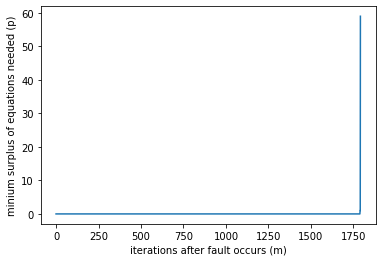

In [17]:
plot = df_m_nonzero_surplus.set_index('m')['surplus'].plot(legend=False)
plot.set_xlabel('iterations after fault occurs (m)')
plot.set_ylabel('minium surplus of equations needed (p)')
fig = plot.get_figure()
fig.savefig("surplusperm.pdf", format="pdf", bbox_inches='tight')
plot

In [18]:
df_by_attack_good_sr = df_by_attack.merge(df_m_nonzero_surplus, on=['m', 'surplus'])
df_by_attack_good_sr

,m,num_signatures,nist_param_level_x,threshold,timeout_limit,surplus,duration,failure,false_positive_rate,percent,nist_param_level_y
0,0,1,5,120,300,0,0.273531,False,0.000000,0.000000,5
1,0,1,5,120,300,0,0.272983,False,0.000000,0.000000,5
2,1,2,5,120,300,0,0.393017,False,0.000000,0.000558,5
3,1,2,5,120,300,0,0.397311,False,0.000000,0.000558,5
4,2,2,5,120,300,0,0.409265,False,0.000000,0.001116,5
5,2,2,5,120,300,0,0.376600,False,0.000000,0.001116,5
6,3,2,5,120,300,0,0.368937,False,0.000000,0.001674,5
7,3,2,5,120,300,0,0.369663,False,0.000000,0.001674,5
8,4,2,5,120,300,0,0.371611,False,0.000000,0.002232,5
9,4,2,5,120,300,0,0.385791,False,0.000000,0.002232,5


In [19]:
df_by_attack_good_sr_successful = df_by_attack_good_sr[df_by_attack_good_sr['failure'] == False]
df_by_attack_good_sr_successful

,m,num_signatures,nist_param_level_x,threshold,timeout_limit,surplus,duration,failure,false_positive_rate,percent,nist_param_level_y
0,0,1,5,120,300,0,0.273531,False,0.000000,0.000000,5
1,0,1,5,120,300,0,0.272983,False,0.000000,0.000000,5
2,1,2,5,120,300,0,0.393017,False,0.000000,0.000558,5
3,1,2,5,120,300,0,0.397311,False,0.000000,0.000558,5
4,2,2,5,120,300,0,0.409265,False,0.000000,0.001116,5
5,2,2,5,120,300,0,0.376600,False,0.000000,0.001116,5
6,3,2,5,120,300,0,0.368937,False,0.000000,0.001674,5
7,3,2,5,120,300,0,0.369663,False,0.000000,0.001674,5
8,4,2,5,120,300,0,0.371611,False,0.000000,0.002232,5
9,4,2,5,120,300,0,0.385791,False,0.000000,0.002232,5


In [24]:
df_by_attack_good_sr_successful_mean = df_by_attack_good_sr_successful.groupby('m').mean()
df_by_attack_good_sr_successful_mean.reset_index().to_json(f'l{nist_security_level}_surplus_sigcount_total.json')
df_by_attack_good_sr_successful_mean

,num_signatures,nist_param_level_x,threshold,timeout_limit,surplus,duration,failure,false_positive_rate,percent,nist_param_level_y
m,,,,,,,,,,
0,1.0,5.0,120.0,300.0,0.0,0.273257,0.0,0.000000,0.000000,5.0
1,2.0,5.0,120.0,300.0,0.0,0.395164,0.0,0.000000,0.000558,5.0
2,2.0,5.0,120.0,300.0,0.0,0.392932,0.0,0.000000,0.001116,5.0
3,2.0,5.0,120.0,300.0,0.0,0.369300,0.0,0.000000,0.001674,5.0
4,2.0,5.0,120.0,300.0,0.0,0.378701,0.0,0.000000,0.002232,5.0
5,2.0,5.0,120.0,300.0,0.0,0.382069,0.0,0.000000,0.002790,5.0
6,2.0,5.0,120.0,300.0,0.0,0.391726,0.0,0.000000,0.003348,5.0
7,2.0,5.0,120.0,300.0,0.0,0.337937,0.0,0.000000,0.003906,5.0
8,2.0,5.0,120.0,300.0,0.0,0.331313,0.0,0.000000,0.004464,5.0


<AxesSubplot:xlabel='iterations after fault occurs (m)', ylabel='average signature count'>

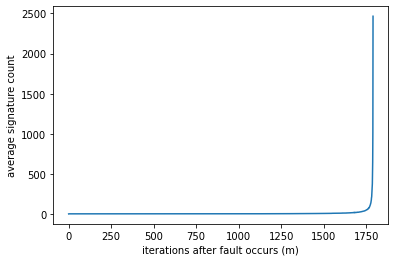

In [21]:
ax = df_by_attack_good_sr_successful_mean.reset_index()['num_signatures'].plot(legend=False)
ax.set_xlabel('iterations after fault occurs (m)')
ax.set_ylabel('average signature count')
fig = ax.get_figure()
fig.savefig("surplussigsperm.pdf", format="pdf", bbox_inches='tight')
ax

Text(0, 0.5, 'avg. false-positive rate')

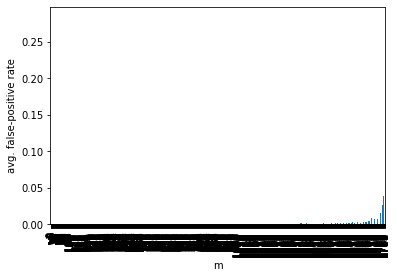

In [22]:
df_by_attack_good_sr_successful_mean['false_positive_rate'].plot(kind='bar', legend=False).set_ylabel("avg. false-positive rate")

Text(0, 0.5, 'avg. duration')

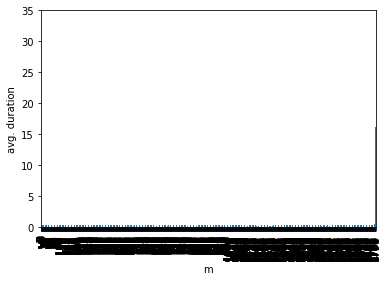

In [23]:
df_by_attack_good_sr_successful_mean['duration'].plot(kind='bar', legend=False).set_ylabel("avg. duration")